In [96]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label

In [2]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

In [3]:
# Read in cars and notcars
images = glob.glob('D:/Self Driving Car Engineer/P5/vehicles/KITTI_extracted/*.png', recursive=True)
images += glob.glob('D:/Self Driving Car Engineer/P5/non-vehicles/**/*.png', recursive=True)
#images = glob.glob('*.jpeg')
cars = []
notcars = []

for image in images:
    if 'non-vehicles' in image:
        #notcars.append(image)
        notcars.append(mpimg.imread(image))
    else:
        #cars.append(image)
        cars.append(mpimg.imread(image))

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features


# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0., 1.)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features



# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for image in imgs:
        file_features = []
        # Read in each one by one
        #image = mpimg.imread(file)
        #image = file
        
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: 
            feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features



# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
        
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    else:
        y_start_stop[0] = int(img.shape[0] * y_start_stop[0] / 100.)
        
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    else:
        y_start_stop[1] = int(img.shape[0] * y_start_stop[1] / 100.)
        
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-nx_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list



# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy




In [5]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: 
        feature_image = np.copy(img)      
        
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

In [6]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))   
        
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [9]:
#save the models and trained info, so no need to retrain
scaler_value= 'C:/CarND-Transfer-Learning-Lab/P5 values/scaler.joblib.pkl'
scaled_x_value = 'C:/CarND-Transfer-Learning-Lab/P5 values/scaled_x.joblib.pkl'
svc_value = 'C:/CarND-Transfer-Learning-Lab/P5 values/svc.joblib.pkl'

In [101]:

def get_features():
    global car_features, notcar_features
    
    car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
    notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
    
def learn_scale():
    global car_features, notcar_features, X_scaler, scaled_X
    
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    X_scaler = StandardScaler().fit(X)  #here we standardize/normalize the data
    joblib.dump(X_scaler, scaler_value, compress=9)  #save the value, so we dont need to do it again
    
    scaled_X = X_scaler.transform(X)  #here we scale our data
    joblib.dump(scaled_X, scaled_x_value, compress=9)  #save the value for future use  
    
def train():
    global car_features, notcar_features, scaled_X, svc
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    rand_state = np.random.randint(0, 100)
    
    # Split up data into randomized training and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        scaled_X, y, test_size=0.2, random_state=rand_state)
    
    svc = LinearSVC() # Use a linear SVC
    
    t = time.time() # Check the training time for the SVC
    svc.fit(x_train, y_train)
    t2 = time.time()
    print(round(t2 - t, 2), 'Seconds to train SVC...')
    print('Test Accuracy of SVC = ', round(svc.score(x_test, y_test), 4))
    joblib.dump(svc, svc_value, compress=9)   #save the values from SVC, so we dont need to do it again
    #return svc



In [11]:
#######################
### TODO: Tweak these parameters and see how the results change.
color_space = 'HLS' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 8  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

In [15]:
from sklearn import svm
from sklearn import datasets
from sklearn.externals import joblib
import os

In [16]:
### Here I have previously trained and learned the SVC values, and I save them for future use
### going through this learning for the first time crashed my computer...

In [17]:
if os.path.isfile(scaler_value):
    print('loading saved scaler value..')
    X_scaler = joblib.load(scaler_value)
    print('Done')
else:
    print('learning scale from start..')
    if car_features is None:
        get_features()
    
    learn_scale
    print('learning Done')
    
#get_features()
#learn_scale()


if os.path.isfile(svc_value):
    print('loading saved SVC values..')
    svc =  joblib.load(svc_value)
    print('Done')
else:
    print('learning SVC from the beginning :(')
    if car_features is None:
        get_features()
    if scaled_X is None:
        scaled_X = joblib.load(scaled_x_value)
        
    train()
    print('Done training')
    
#train()

loading saved scaler value..
Done
loading saved SVC values..
Done


In [206]:
####################### lets experiment with 1 image!!!  
image = mpimg.imread('D:/Self Driving Car Engineer/P5/bbox-example-image.jpg')
#image = mpimg.imread('D:/Self Driving Car Engineer/P5/CarND-Vehicle-Detection-master/test_images/test6.jpg')
draw_image = np.copy(image)

# Uncomment the following line if you extracted training
# data from .png images (scaled 0 to 1 by mpimg) and the
# image you are searching is a .jpg (scaled 0 to 255)
image = image.astype(np.float32)/255
##########################################



#different window sizes for the cars
window_sizes = [64,96,128,]

#We search 3 sections of the image, from the centre of road, all the way to front of camera
y_start_stop = [[65, 77],[65, 83],[65, 95],  ]

#Here we search for the multiple window sizes
windows = []
for i in range(len(window_sizes)):
    windows += slide_window(
        image, x_start_stop=[None, None], y_start_stop=y_start_stop[i],
        xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)               

plt.imshow(window_img)

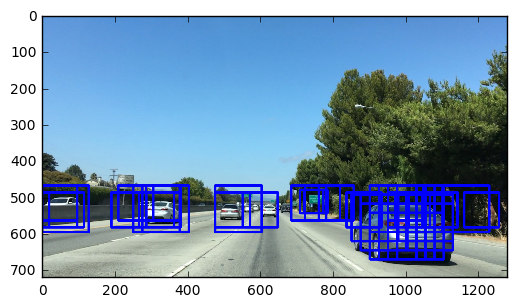

In [72]:
plt.show()
#plt.savefig("D:/Self Driving Car Engineer/P5/boxes.png")

In [65]:
#plt.imshow(window_img)
#plt.show()


In [312]:
from scipy.ndimage.measurements import label
labels = label(heatmap)

In [357]:
import collections
import numpy as np

frame_boxes_list = collections.deque(maxlen=10)

def add_boxes(boxes):
    frame_boxes_list.append(boxes)

def add_heat(img):
    heat = np.zeros_like(img[:, :, 0]).astype(np.float)

    for frame_boxes in frame_boxes_list:
        for box in frame_boxes:
            heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    return apply_threshold(heatmap, 2)


def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [358]:
def draw_labeled_bboxes(img, labels):
    for car_number in range(1, labels[1] + 1):
        nonzero = (labels[0] == car_number).nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        cv2.rectangle(img, bbox[0], bbox[1], (0, 0, 255), 6)
        return img

In [315]:
'''heat = np.zeros_like(image[:, :, 0]).astype(np.float)
heat = add_heat(heat, window_img)  #do i need a whole bunch of images with boxes here?
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)'''

'heat = np.zeros_like(image[:, :, 0]).astype(np.float)\nheat = add_heat(heat, window_img)  #do i need a whole bunch of images with boxes here?\n    \n# Apply threshold to help remove false positives\nheat = apply_threshold(heat,1)\n\n# Visualize the heatmap when displaying    \nheatmap = np.clip(heat, 0, 255)\n\n# Find final boxes from heatmap using label function\nlabels = label(heatmap)\ndraw_img = draw_labeled_bboxes(np.copy(image), labels)'

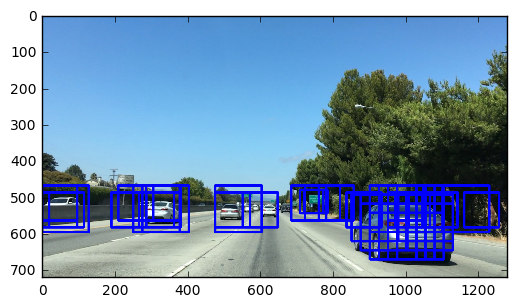

In [359]:
plt.imshow(window_img)
plt.show()

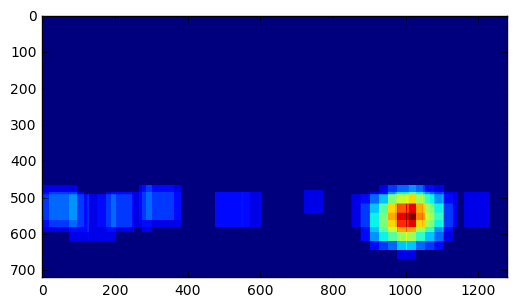

In [360]:
#heat = np.zeros_like(window_img[:,:,0]).astype(np.float)
heat = add_heat(window_img)
plt.imshow(heat)
plt.show()

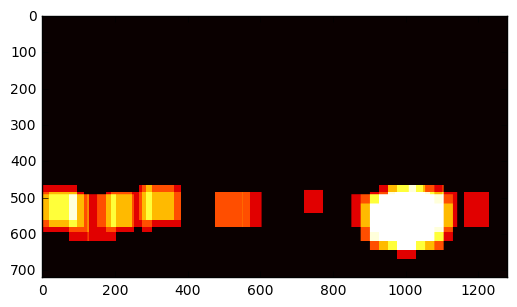

In [364]:
heatmap = np.clip(heat, 0, 255)
plt.imshow(heatmap, cmap='hot')
plt.show()

5 cars found


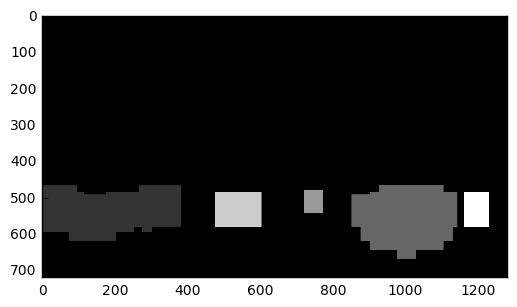

In [373]:

heatmap = apply_threshold(heatmap, 2 )

labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

In [374]:
def process_image(img):
    global windows
    draw_image = np.copy(img)
    img = img.astype(np.float32) / 255
    
    hot_windows = search_windows(img, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)   
    
    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
    #add_boxes(hot_windows)
    
    heatmap = add_heat(window_img) #img or window_img??

    labels = label(heatmap)

    return draw_labeled_bboxes(draw_image, labels)


In [375]:
#different window sizes for the cars
window_sizes = [64,96,128,]

#We search 3 sections of the image, from the centre of road, all the way to front of camera
y_start_stop = [[65, 77],[65, 83],[65, 95],  ]

#Here we search for the multiple window sizes
windows = []
for i in range(len(window_sizes)):
    windows += slide_window(
        image, x_start_stop=[None, None], y_start_stop=y_start_stop[i],
        xy_window=(window_sizes[i], window_sizes[i]), xy_overlap=(0.8, 0.8))


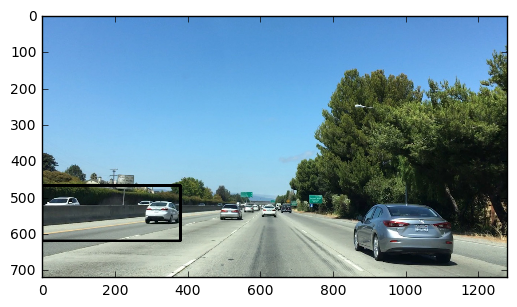

In [376]:
process_image(image)
plt.imshow(process_image(image))
plt.show()


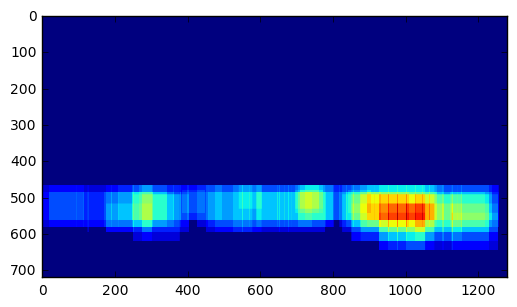

In [201]:
z = add_heat(window_img)
plt.imshow(z)
plt.show()